# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

## Step 1: Build + inspect used Tesseracts

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

### Explore Design Space Tesseract

First, let's import the Tesseract Core library and start a server for the design space Tesseract, which is equivalent to the function $g$ in the equation above.

In [70]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [75]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("design_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [76]:
n_chains = 2
n_edges_per_chain = 2
bar_radius = 0.5

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 100, 50, 50

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
        "static_parameters": [n_chains, n_edges_per_chain + 1],
        "string_parameters": [],
        "mesh_tesseract": TesseractReference(bar_3d_tess),
        "grid_size": [Lx, Ly, Lz],
        "grid_elements": [Nx, Ny, Nz],
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 180
Number of faces: 352
SDF shape: (100, 50, 50)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

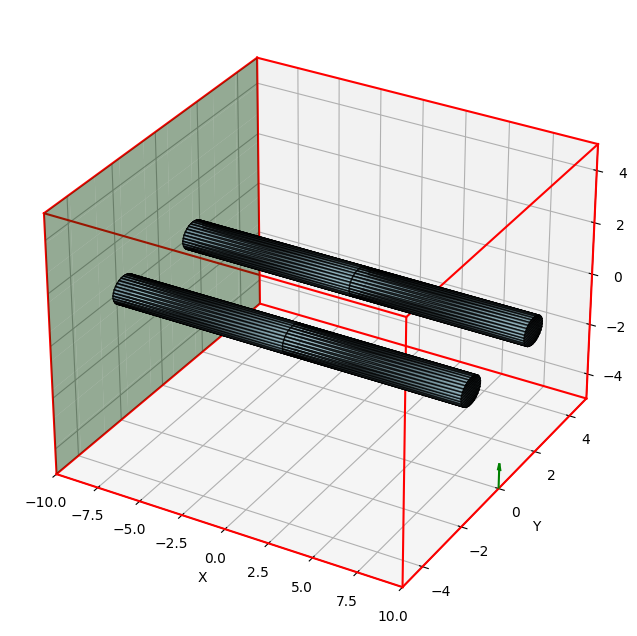

In [77]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # same as above in loop
    for x in [-Lx / 2, Lx / 2]:
        for y in [-Ly / 2, Ly / 2]:
            ax.plot(
                [x, x],
                [y, y],
                [-Lz / 2, Lz / 2],
                color="red",
            )
    for x in [-Lx / 2, Lx / 2]:
        for z in [-Lz / 2, Lz / 2]:
            ax.plot(
                [x, x],
                [-Ly / 2, Ly / 2],
                [z, z],
                color="red",
            )
    for y in [-Ly / 2, Ly / 2]:
        for z in [-Lz / 2, Lz / 2]:
            ax.plot(
                [-Lx / 2, Lx / 2],
                [y, y],
                [z, z],
                color="red",
            )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

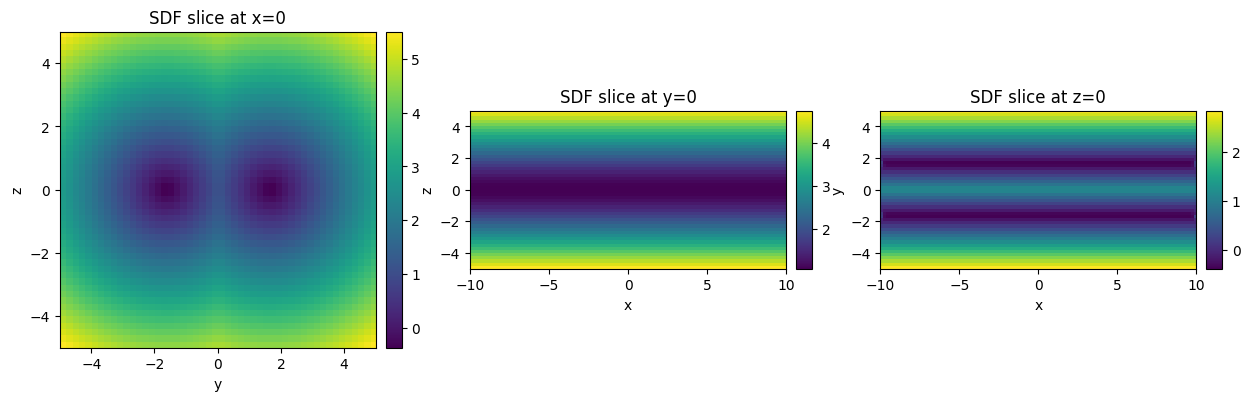

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_sdf_slice(sdf_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(sdf_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_sdf(sdf, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_sdf_slice(
        sdf[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_sdf_slice(
        sdf[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_sdf_slice(
        sdf[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_sdf(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

In [80]:
primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": initial_params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (2, 3, 3)
